# Initial Settings

In [7]:
#!pip install pandas numpy matplotlib seaborn tabulate scikit-learn

In [ ]:
# Imports & settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import plotly.express as px
import plotly.colors as pc

from scipy import stats
from scipy.stats import gaussian_kde
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
#from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display, Markdown

# Data Loading and Inspection

In [33]:
# Change file path or dataset name if necessary
file_path = 'VGSales_4054.csv'

# Load the dataset with Pandas
df = pd.read_csv(file_path, low_memory=False)

# Display the first few rows to observe data structure
print("The first few rows of the data set:\n")
display(df.head())
print("\nData Summary:\n")
display(df.info())

The first few rows of the data set:



,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,NaN,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,NaN,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,NaN
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37



Data Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          5000 non-null   int64  
 1   Name          5000 non-null   object 
 2   Platform      5000 non-null   object 
 3   Year          4931 non-null   float64
 4   Genre         5000 non-null   object 
 5   Publisher     4990 non-null   object 
 6   NA_Sales      5000 non-null   float64
 7   EU_Sales      4999 non-null   float64
 8   JP_Sales      5000 non-null   float64
 9   Other_Sales   4999 non-null   float64
 10  Global_Sales  4999 non-null   float64
dtypes: float64(6), int64(1), object(4)
memory usage: 429.8+ KB


None

In [34]:
# Checking duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Checking for missing values inside of the dataset
print ( '\nMissing values')
print (df. isnull().sum())

Duplicate rows: 0

Missing values
Rank             0
Name             0
Platform         0
Year            69
Genre            0
Publisher       10
NA_Sales         0
EU_Sales         1
JP_Sales         0
Other_Sales      1
Global_Sales     1
dtype: int64


# Data Pre-Processing & Feature Engineering

In [35]:
# Trim whitespace in object columns
str_cols = df.select_dtypes(include='object').columns.tolist()
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

# Standardize column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Replace NaN values in Publisher with 'Unknown Publisher'
df['Publisher'] = df['Publisher'].fillna('Unknown Publisher')

# Year handling: create a single column 'Release_Year' with date format (year only)
if 'Year' in df.columns:
    # Convert to numeric, invalid parsing becomes NaN
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    # Create Release_Year as datetime, using January 1st for missing day/month
    df['Release_Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')

# Rank conversions
if 'Rank' in df.columns:
    # sometimes strings exist
    df['Rank'] = pd.to_numeric(df['Rank'], errors='coerce')

# Identify regional sales columns (exclude 'Global_Sales')
region_cols = [c for c in df.columns if c.endswith('_Sales') and c != 'Global_Sales']
print('Detected regional columns:', region_cols)

# Fill NaN values in regional sales columns with the average of that column
for col in region_cols:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)

# Compute Global_Sales if missing
df['Global_Sales'] = df['Global_Sales'].fillna(df[region_cols].sum(axis=1))

# Check remaining missing values
missing = df.isna().sum().sort_values(ascending=False)
print('Remaining missing values:')
display(missing[missing > 0].head())


Detected regional columns: ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
Remaining missing values:


Year            69
Release_Year    69
dtype: int64

In [36]:
# Dropped the original 'Year' column since no longer needed
#df.drop(columns=['Year'], inplace=True)

# Calculating the total number of missing cells in the dataset
null_values = df.isnull().sum().sum()
print("\nTotal number of null values in the data set are:", null_values)

# Calculate total fields in the data set
total_values = df.size
print('Total data fields in the report are:', total_values)

# Calculate the percentage of missing valuesu of data set
anomalies = (null_values / total_values) * 100
print (f'The missing values represent {anomalies:.2f}% of the entire data values.')


Total number of null values in the data set are: 138
Total data fields in the report are: 60000
The missing values represent 0.23% of the entire data values.


In [37]:
# Remove rows with empty vallues
df.dropna(axis=0,inplace=True)

# Check for missing values after imputation
print("Number of null values:", df.isnull().sum().sum())

# Duplicates after removal
print("Number of duplicate rows:", df.duplicated().sum(), "\n")

print (df.info())

Number of null values: 0
Number of duplicate rows: 0 

<class 'pandas.core.frame.DataFrame'>
Index: 4931 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rank          4931 non-null   int64         
 1   Name          4931 non-null   object        
 2   Platform      4931 non-null   object        
 3   Year          4931 non-null   float64       
 4   Genre         4931 non-null   object        
 5   Publisher     4931 non-null   object        
 6   NA_Sales      4931 non-null   float64       
 7   EU_Sales      4931 non-null   float64       
 8   JP_Sales      4931 non-null   float64       
 9   Other_Sales   4931 non-null   float64       
 10  Global_Sales  4931 non-null   float64       
 11  Release_Year  4931 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1), object(4)
memory usage: 500.8+ KB
None


# Descriptive Statistical Analysis

In [38]:
# Count unique values across multiple non-numeric columns
total_publishers = df['Publisher'].nunique()
total_platforms = df['Platform'].nunique()
total_genres = df['Genre'].nunique()
total_names = df['Name'].nunique()

print("Total Unique Publishers:", total_publishers)
print("Total Unique Platforms:", total_platforms)
print("Total Unique Genres:", total_genres)
print("Total Unique Names:", total_names)

# Declaration of a variable to hold numerical sales data
numerical_data = df.loc[:, df.dtypes == 'float64']
print("\n\nInitial Data Summary:\n")
display( numerical_data.describe().round(4))

Total Unique Publishers: 194
Total Unique Platforms: 26
Total Unique Genres: 12
Total Unique Names: 3507


Initial Data Summary:



,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,4931.0000,4931.0000,4931.0000,4931.0000,4931.0000,4931.0000
mean,2005.3529,0.7387,0.4278,0.1960,0.1395,1.5022
std,6.6335,1.3793,0.8593,0.5511,0.3237,2.6019
min,1980.0000,0.0000,0.0000,0.0000,0.0000,0.3800
25%,2002.0000,0.2400,0.0900,0.0000,0.0300,0.5400
50%,2007.0000,0.4200,0.2200,0.0000,0.0700,0.8300
75%,2010.0000,0.7800,0.4500,0.1300,0.1400,1.5100
max,2016.0000,41.4900,29.0200,10.2200,10.5700,82.7400


In [39]:
def kpis(df, date_col='Release_Year'):
    total_sales = df['Global_Sales'].sum()
    if date_col in df.columns and not df[date_col].isna().all():
        df_year = df.copy()
        df_year['year'] = df_year[date_col].dt.year
        yearly = df_year.groupby('year')['Global_Sales'].sum().sort_index()
        if len(yearly) >= 2:
            yoy = (yearly.iloc[-1] - yearly.iloc[-2]) / yearly.iloc[-2] if yearly.iloc[-2] != 0 else np.nan
        else:
            yoy = np.nan
        first_year, last_year = yearly.index.min(), yearly.index.max()
    else:
        yoy = np.nan
        first_year, last_year = None, None

    top_platform = df.groupby('Platform', as_index=False)['Global_Sales'].sum() if 'Platform' in df.columns else pd.DataFrame()
    top_platform = top_platform.sort_values('Global_Sales', ascending=False).head(1)['Platform'].iloc[0] if not top_platform.empty else None
    top_genre = df.groupby('Genre', as_index=False)['Global_Sales'].sum() if 'Genre' in df.columns else pd.DataFrame()
    top_genre = top_genre.sort_values('Global_Sales', ascending=False).head(1)['Genre'].iloc[0] if not top_genre.empty else None
    avg_per_title = df['Global_Sales'].mean()
    return dict(
        total_sales=total_sales,
        yoy=yoy,
        first_year=first_year,
        last_year=last_year,
        top_platform=top_platform,
        top_genre=top_genre,
        avg_per_title=avg_per_title
    )

# KPIs
kpis = kpis(df)
display(Markdown("## Executive KPIs"))
display(Markdown(f"- **Total global sales:** {kpis['total_sales']:.2f}"))
if kpis['first_year'] is not None:
    display(Markdown(f"- **Period:** {kpis['first_year']} — {kpis['last_year']}"))
display(Markdown(f"- **YoY (latest year):** {kpis['yoy']:.2%}" if not np.isnan(kpis['yoy']) else "- **YoY:** N/A"))
display(Markdown(f"- **Top platform:** {kpis['top_platform']}"))
display(Markdown(f"- **Top genre:** {kpis['top_genre']}"))
display(Markdown(f"- **Avg sales per title:** {kpis['avg_per_title']:.3f}"))

## Executive KPIs

- **Total global sales:** 7407.47

- **Period:** 1980 — 2016

- **YoY (latest year):** -79.64%

- **Top platform:** PS2

- **Top genre:** Action

- **Avg sales per title:** 1.502

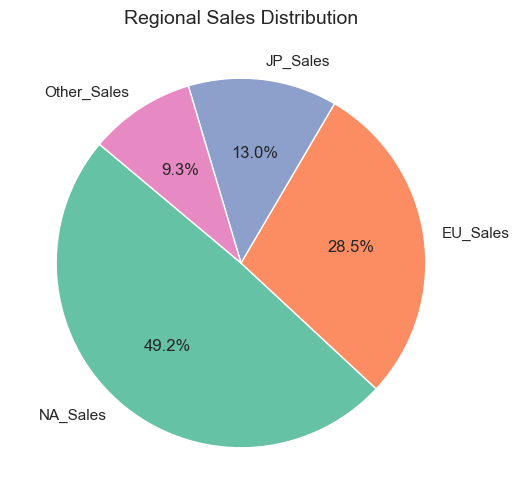

In [40]:
# Select regional sales
region_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
sales_totals = df[region_cols].sum()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    sales_totals,
    labels=sales_totals.index,
    autopct='%1.1f%%',        # show percentages with 1 decimal
    startangle=140,
    colors=sns.color_palette("Set2")  # Seaborn color palette
)
plt.title("Regional Sales Distribution", fontsize=14)
plt.show()

In [41]:
# Function Definition for top ten bar chart
def top_cat_sale(df, by='Genre', n=10, sales_col='Global_Sales', title=None,
                 width=1000, height=500, palette=None):
    """
    Creates a horizontal annotated bar chart showing the top categories by total sales.
    """
    if by not in df.columns:
        display(Markdown(f"Column `{by}` not in data."))
        return

    # Aggregate and sort data
    agg = (
        df.groupby(by, as_index=False)[sales_col]
        .sum()
        .sort_values(sales_col, ascending=False)
        .head(n)
    )

    # Create horizontal bar chart
    fig = px.bar(
        agg,
        x=sales_col,
        y=by,
        orientation='h',
        text=sales_col,
        title=title or f"Top {n} {by}s by {sales_col}",
        width=width,
        height=height,
        color=by,
        color_discrete_sequence=palette
    )

    # Update layout and annotation
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(yaxis={'categoryorder': 'total ascending'})
    fig.show()

# Top 10 Genres by Global Sales (Pastel colors)
top_cat_sale(
    df,
    by='Genre',
    n=10,
    title="Top 10 Genres by Global Sales",
    width=1000,
    height=500,
    palette=px.colors.qualitative.Pastel
)

In [42]:
# Top 10 Platforms by Global Sales (Viridis sequential gradient)
top_cat_sale(
    df,
    by='Platform',
    n=10,
    title="Top 10 Platforms by Global Sales",
    width=1000,
    height=500,
    palette=px.colors.sequential.Viridis
)

In [43]:
# Top 10 Publishers by Global Sales (Set2 qualitative palette)
top_cat_sale(
    df,
    by='Publisher',
    n=10,
    title="Top 10 Publishers by Global Sales",
    width=1000,
    height=500,
    palette=px.colors.qualitative.Set2
)

In [44]:
# Cell: Sales over time (aggregate) with annotations for peaks
def aggregate_timeseries(df, date_col='Release_Year', sales_col='Global_Sales', freq='YE'):
    ts = df.dropna(subset=[date_col]).copy()
    ts = ts.set_index(date_col).resample(freq)[sales_col].sum().rename(sales_col).to_frame().reset_index()
    return ts

if not df['Release_Year'].isna().all():
    ts = aggregate_timeseries(df, freq='YE')
    fig = px.line(ts, x='Release_Year', y='Global_Sales', title='Global Sales Over Time (Yearly)')
    # annotate top peaks
    peaks = ts.sort_values('Global_Sales', ascending=False).head(3)
    for _, r in peaks.iterrows():
        fig.add_annotation(x=r['Release_Year'], y=r['Global_Sales'],
                           text=f"{r['Global_Sales']:.2f}", showarrow=True, arrowhead=2)
    fig.update_layout(width=1000, height=500)
    fig.show()
else:
    display(Markdown("No valid release_date found — cannot produce time series."))

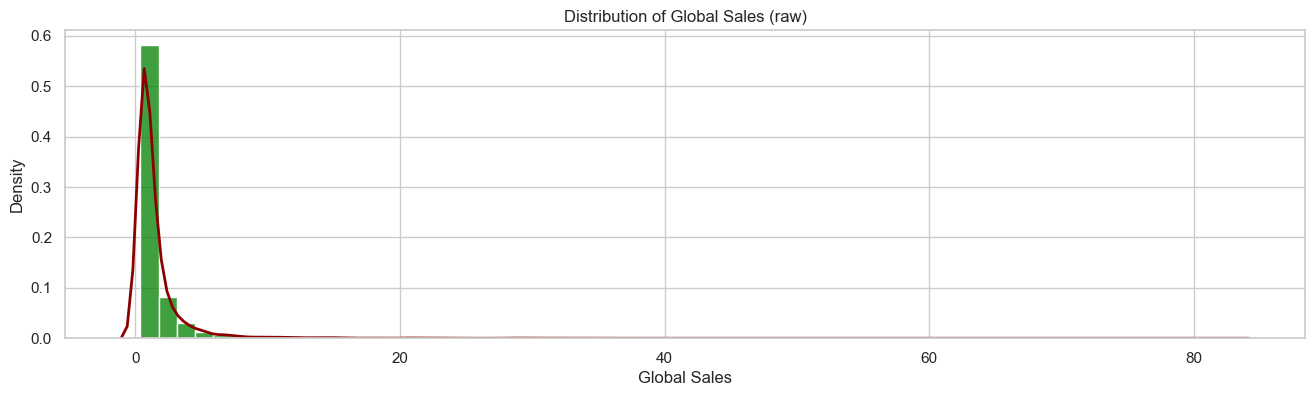

In [45]:
# Raw Global Sales
plt.figure(figsize=(16, 4))
sns.histplot(df['Global_Sales'], bins=60, color='green', stat='density')  # histogram
sns.kdeplot(df['Global_Sales'], color='darkred', linewidth=2)  # KDE line
plt.title('Distribution of Global Sales (raw)')
plt.xlabel('Global Sales')
plt.ylabel('Density')
plt.show()

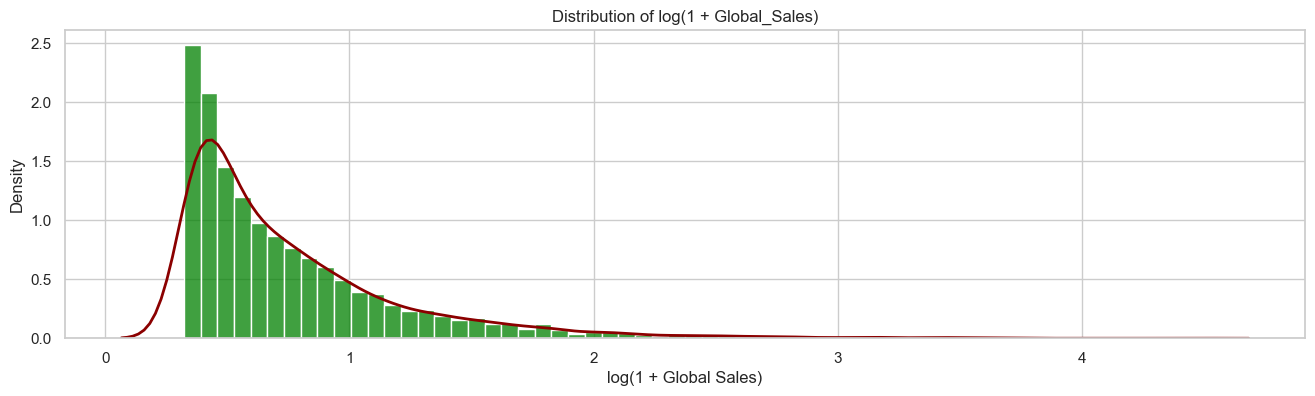

In [46]:
# Log-transformed Global Sales
df['Log_Global_Sales'] = np.log1p(df['Global_Sales'])

plt.figure(figsize=(16, 4))
sns.histplot(df['Log_Global_Sales'], bins=60, color='green', stat='density')
sns.kdeplot(df['Log_Global_Sales'], color='darkred', linewidth=2)
plt.title('Distribution of log(1 + Global_Sales)')
plt.xlabel('log(1 + Global Sales)')
plt.ylabel('Density')
plt.show()

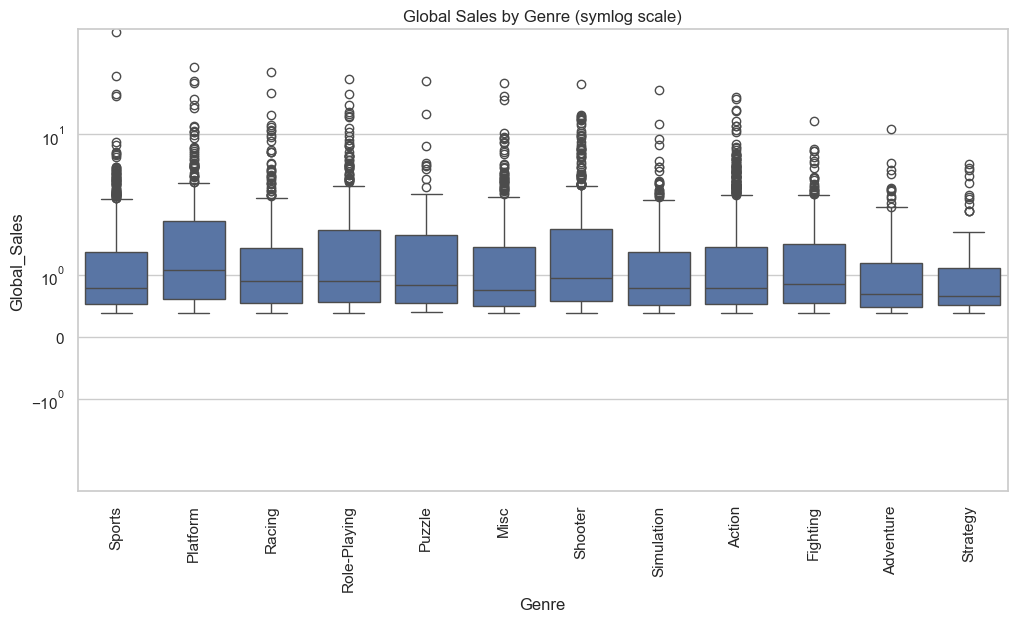

In [47]:
# Boxplot of Global Sales by Genre
if 'Genre' in df.columns and 'Global_Sales' in df.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(x='Genre', y='Global_Sales', data=df)
    plt.xticks(rotation=90)
    plt.yscale('symlog')
    plt.title('Global Sales by Genre (symlog scale)')
    plt.show()

In [48]:
# Numerical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculation of z-scores
z_scores = np.abs((numeric_columns - numeric_columns.mean()) / numeric_columns.std())

# Set threshold as 3 standard deviations
threshold = 3

# Counting outliers in each column
outliers = (z_scores > threshold).sum()

# Print outliers for each column
print("Number of outliers:")
print(outliers)

Number of outliers:
Rank                 0
Year                97
NA_Sales            62
EU_Sales            68
JP_Sales            94
Other_Sales         61
Global_Sales        71
Log_Global_Sales    93
dtype: int64


# Statistical Inferential Analysis with Hypothesis Testing

In [49]:
# Inferential statistics
# ANOVA: Identify if there are enough diffrence amoung genres in mean global sales.
if 'Genre' in df.columns and 'Global_Sales' in df.columns:
    genre_counts = df['Genre'].value_counts()
    kept_genres = genre_counts[genre_counts >= 30].index.tolist()
    if len(kept_genres) > 1:
        test_df = df[df['Genre'].isin(kept_genres)].copy()
        groups = [group['Global_Sales'].dropna().values for name, group in test_df.groupby('Genre')]
        fstat, pval = stats.f_oneway(*groups)
        print('ANOVA across genres: F-stat =', fstat, ', p-value =', pval)
    else:
        print('Not enough genres with >=30 records for robust ANOVA.')

# Pairwise t-test: Identifying the difference between top two genres in mean global sales.
if 'Genre' in df.columns:
    top_two = df['Genre'].value_counts().index[:2].tolist()
    if len(top_two) == 2:
        a = df[df['Genre']==top_two[0]]['Global_Sales'].dropna()
        b = df[df['Genre']==top_two[1]]['Global_Sales'].dropna()
        tstat, pval = stats.ttest_ind(a, b, equal_var=False)
        print(f'T-test {top_two[0]} vs {top_two[1]}: t={tstat:.3f}, p={pval:.3g}')

ANOVA across genres: F-stat = 4.086933002426457 , p-value = 5.276246091612939e-06
T-test Action vs Sports: t=0.126, p=0.9


# Correlation & Trend Analysis

In [50]:
# Correlation heatmap for numeric columns
selected_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Select numerical columns for correlation analysis
selected_columns = ['Release_Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
numerical_columns = df[selected_columns]

# Produce correlation matrix with pandas
correlation_matrix = numerical_columns.corr()

# Print correlation matrix with column names aligned
print("Correlation Matrix:")
print(correlation_matrix.to_string())

Correlation Matrix:
              Release_Year  NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
Release_Year      1.000000 -0.068298  0.085581 -0.201292     0.126351     -0.035596
NA_Sales         -0.068298  1.000000  0.720266  0.422963     0.570725      0.932261
EU_Sales          0.085581  0.720266  1.000000  0.397293     0.669402      0.879184
JP_Sales         -0.201292  0.422963  0.397293  1.000000     0.237458      0.596586
Other_Sales       0.126351  0.570725  0.669402  0.237458     1.000000      0.695579
Global_Sales     -0.035596  0.932261  0.879184  0.596586     0.695579      1.000000


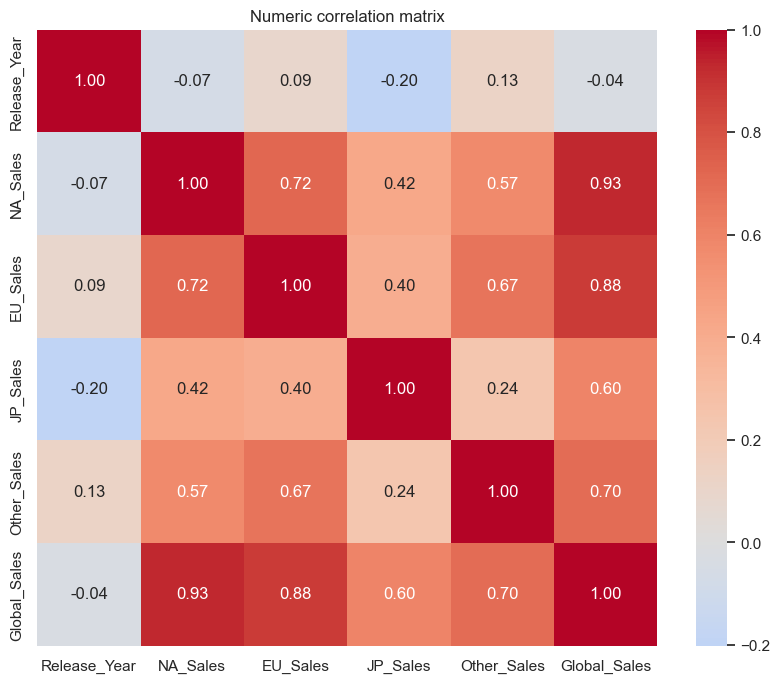

In [51]:
plt.figure(figsize=(10,8))
sns.heatmap(df[selected_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title('Numeric correlation matrix')
plt.show()

C:\Users\rahma\AppData\Local\Temp\ipykernel_29808\1599955928.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



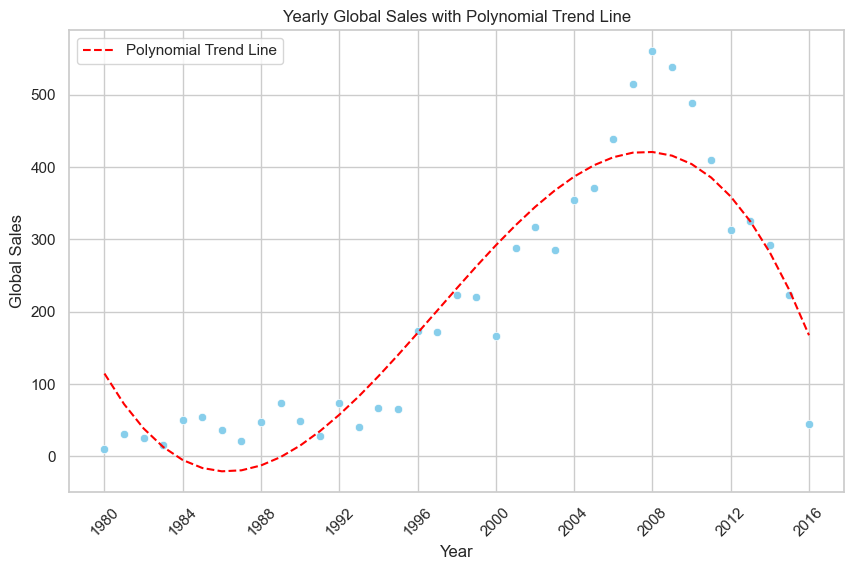

In [52]:
# Yearly Global Sales Polynomial Trend
# Group the data by year and calculate total Global Sales
yearly_sales = df.groupby('Release_Year')['Global_Sales'].sum().reset_index()

# Ensure Release_Year is in datetime format for plotting
yearly_sales['Date'] = pd.to_datetime(yearly_sales['Release_Year'].astype(str) + '-01-01')

# Fit a polynomial trend line (degree 3)
coefficients = np.polyfit(np.arange(len(yearly_sales)), yearly_sales['Global_Sales'], 3)
poly_function = np.poly1d(coefficients)

# Plot the scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Date', y='Global_Sales', data=yearly_sales, color='skyblue')
plt.plot(yearly_sales['Date'], poly_function(np.arange(len(yearly_sales))),
         color='red', linestyle='--', label='Polynomial Trend Line')
plt.title('Yearly Global Sales with Polynomial Trend Line')
plt.xlabel('Year')
plt.ylabel('Global Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Future Video Game Sales

In [53]:
# Time Series Analysis: Global Sales
if 'Release_Year' in df.columns and df['Release_Year'].notna().any():
    # Aggregate yearly sales
    ts = df.groupby('Release_Year')['Global_Sales'].sum().sort_index()

    # check min/max of Release_Year
    print("Min Release Year:", df['Release_Year'].min())
    print("Max Release Year:", df['Release_Year'].max())

    # Handle datetime vs numeric year
    if np.issubdtype(ts.index.dtype, np.datetime64):
        ts.index = pd.to_datetime(ts.index).to_period("Y").to_timestamp()
    else:
        ts.index = pd.to_numeric(ts.index, errors='coerce')
        ts = ts.dropna()
        ts = ts[(ts.index >= 1970) & (ts.index <= 2030)]
        ts.index = pd.to_datetime(ts.index.astype(int).astype(str), format='%Y')

    # Ensure yearly frequency
    ts = ts.asfreq('YS')

    # Check if empty
    if ts.empty:
        print("Time series is empty after processing.")
    else:
        # display(ts)
        extremes = ts.loc[[ts.idxmin(), ts.idxmax()]]
        display(extremes)

else:
    print('Release_Year or Global_Sales missing — cannot build time series aggregation.')


Min Release Year: 1980-01-01 00:00:00
Max Release Year: 2016-01-01 00:00:00


Release_Year
1980-01-01     10.53
2008-01-01    559.87
Name: Global_Sales, dtype: float64

In [54]:
# Forcasting Global Sales
try:
    # Upsample yearly data to monthly
    ts_monthly = ts.resample('MS').interpolate(method='linear')

    forcast = ARIMA(ts_monthly.dropna(), order=(1,1,1))
    forcast_res = forcast.fit()

    # Forecast 12 months
    n_forecast = 12
    fc = forcast_res.get_forecast(steps=n_forecast)
    fc_index = pd.date_range(ts_monthly.index[-1] + pd.DateOffset(months=1),
                             periods=n_forecast, freq='MS')

    # Put forecast in DataFrame
    forecast_df = pd.DataFrame({
        'Forecast': fc.predicted_mean,
        'Lower CI': fc.conf_int().iloc[:,0],
        'Upper CI': fc.conf_int().iloc[:,1]
    }, index=fc_index)

    print("\n12-Month Forecast:")
    print(forecast_df)
except Exception as e:
    print("Error:", e)


12-Month Forecast:
             Forecast    Lower CI   Upper CI
2016-02-01  31.342537   28.341173  34.343901
2016-03-01  17.907861   11.253310  24.562413
2016-04-01   5.122951   -5.858151  16.104052
2016-05-01  -7.043621  -22.869100   8.781859
2016-06-01 -18.621759  -39.703108   2.459589
2016-07-01 -29.639924  -56.310545  -2.969304
2016-08-01 -40.125198  -72.658218  -7.592177
2016-09-01 -50.103354  -88.723767 -11.482942
2016-10-01 -59.598919 -104.492336 -14.705502
2016-11-01 -68.635234 -119.954476 -17.315991
2016-12-01 -77.234509 -135.104724 -19.364294
2017-01-01 -85.417883 -149.940626 -20.895139


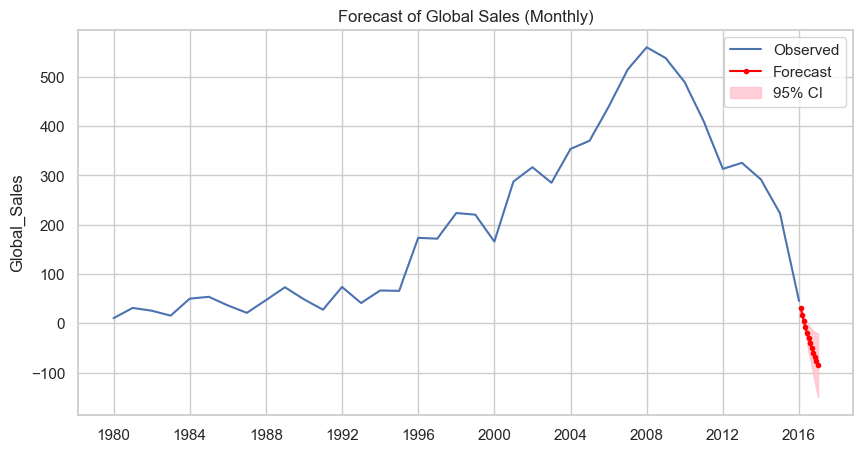

In [55]:
try:
    # Plot forecast
    plt.figure(figsize=(10,5))
    plt.plot(ts_monthly, label='Observed')
    plt.plot(forecast_df.index, forecast_df['Forecast'], marker='.', color='red', label='Forecast')
    plt.fill_between(forecast_df.index,
                     forecast_df['Lower CI'],
                     forecast_df['Upper CI'],
                     color='pink', alpha=0.75, label='95% CI')
    plt.title('Forecast of Global Sales (Monthly)')
    plt.ylabel('Global_Sales')
    plt.legend()
    plt.show()
except Exception as e:
    print("Error:", e)